In [1]:
%matplotlib inline
import numpy as np
import math as m
from matplotlib import pyplot as plt
import random
from IPython.display import Image

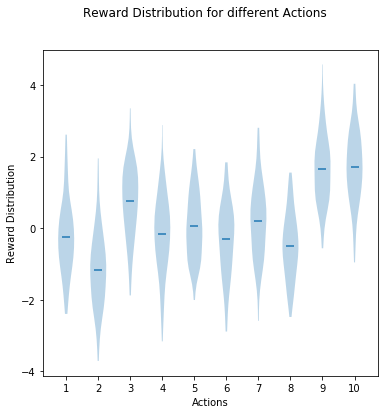

In [2]:
## K-armed testbed
def plot_reward(k=10):
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    
    action_labels = [x+1 for x in range(k)]
    optimal_action_values = np.random.normal(0, 1, size=k)
    rewards = [np.random.normal(optimal_action_values, 1, 100) for optimal_action_values in optimal_action_values]
    
    axes.violinplot(rewards, action_labels, points=20,
                    showmeans=True, showextrema=False, showmedians=False)
    axes.set_xlabel("Actions")
    axes.set_xticks(action_labels)
    axes.set_ylabel("Reward Distribution")
    fig.suptitle("Reward Distribution for different Actions")
    
    plt.show()
    
plot_reward(k=10)

In [3]:
np.random.seed(13)
fixed_optimal_values = np.random.normal(0, 1, 10)
print(fixed_optimal_values)

[-0.71239066  0.75376638 -0.04450308  0.45181234  1.34510171  0.53233789
  1.3501879   0.86121137  1.47868574 -1.04537713]


In [4]:
def epsilon_greedy_experiment(fixed_optimal_values, initial_expectation=0, k=10, epsilon=0, time_steps=1000):
    
    #tracking variables
    q_est = np.ones(k) * initial_expectation
    prev_trials = np.zeros(k)
    sum_prev_rewards = 0
    average_reward = list()
    
    #bandit environment returns reward
    def bandit(action_choosen):
        return np.random.normal(fixed_optimal_values[action_choosen], 1)
    
    #Simulation for time_steps
    for i in range(time_steps):
        prob = np.random.random_sample()
        
        if prob <= epsilon:
            action_choosen = np.random.randint(0, 10)
        else:
            indexes_of_max_values = np.argwhere(q_est == np.amax(q_est)).flatten().tolist()
            action_choosen = random.choice(indexes_of_max_values)
        
        reward_t = bandit(action_choosen)
        prev_trials[action_choosen] += 1
        q_est[action_choosen] += (reward_t-q_est[action_choosen]) / prev_trials[action_choosen]
        
        sum_prev_rewards += reward_t
        average_reward.append(sum_prev_rewards/(i+1))
        
    return average_reward

In [5]:
def run_exps(fixed_optimal_values=fixed_optimal_values, initial_expectation=0, k=10, epsilon=0, time_steps=1000, n=2000):
    average_return = list()
    for i in range(n):
        average_return.append(epsilon_greedy_experiment(fixed_optimal_values, initial_expectation, k, epsilon, time_steps))
    
    return(np.mean(average_return, axis=0))

CPU times: user 2min, sys: 359 ms, total: 2min
Wall time: 2min


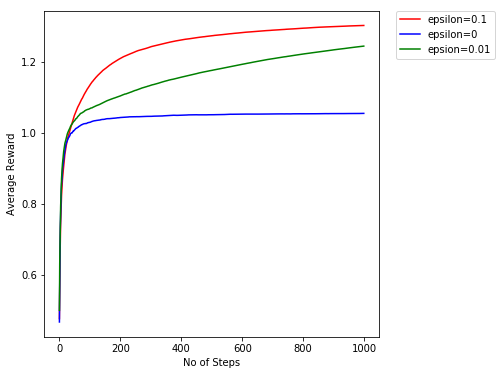

In [6]:
%%time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axes.plot(run_exps(epsilon=0.1),color='r', label="epsilon=0.1")
axes.plot(run_exps(epsilon=0),color='b',label="epsilon=0")
axes.plot(run_exps(epsilon=0.01), color='g',label="epsion=0.01")
axes.set_xlabel("No of Steps")
axes.set_ylabel("Average Reward")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

CPU times: user 2min, sys: 304 ms, total: 2min 1s
Wall time: 2min 1s


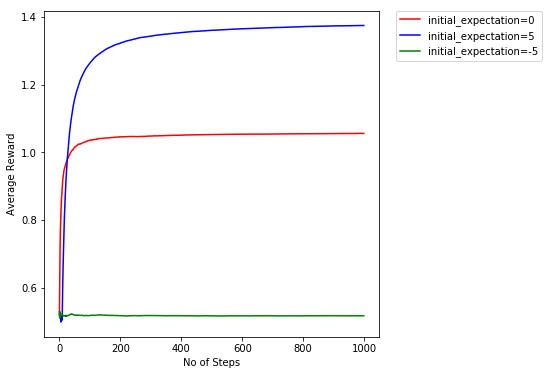

In [7]:
%%time
#Optimistic Initial Values
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axes.plot(run_exps(initial_expectation=0),color='r', label="initial_expectation=0")
axes.plot(run_exps(initial_expectation=5),color='b',label="initial_expectation=5")
axes.plot(run_exps(initial_expectation=-5), color='g',label="initial_expectation=-5")
axes.set_xlabel("No of Steps")
axes.set_ylabel("Average Reward")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
def UCB(fixed_optimal_values, initial_expectation=0, k=10, c=2, time_steps=1000):
    
    #tracking variables
    q_est = np.ones(k) * initial_expectation
    prev_trials = np.zeros(k)
    sum_prev_rewards = 0
    average_reward = list()
    
    #bandit environment returns reward
    def bandit(action_choosen):
        return np.random.normal(fixed_optimal_values[action_choosen], 1)
    
    #Simulation for time_steps
    for i in range(time_steps):
       
        if i==0:
            action_choosen = 0
        else:
            ucb_term = q_est + (c * np.sqrt(m.log(i)/(prev_trials+1e-4)))
            action_choosen = np.argmax(ucb_term)
        
        reward_t = bandit(action_choosen)
        prev_trials[action_choosen] += 1
        q_est[action_choosen] += (reward_t-q_est[action_choosen]) / prev_trials[action_choosen]
        
        sum_prev_rewards += reward_t
        average_reward.append(sum_prev_rewards/(i+1))
        
    return average_reward

In [9]:
def run_exps_ucb(fixed_optimal_values=fixed_optimal_values, initial_expectation=0, k=10, c=2, time_steps=1000, n=2000):
    average_return = list()
    for i in range(n):
        average_return.append(UCB(fixed_optimal_values, initial_expectation, k, c, time_steps))
    
    return(np.mean(average_return, axis=0))

CPU times: user 58.9 s, sys: 156 ms, total: 59 s
Wall time: 59 s


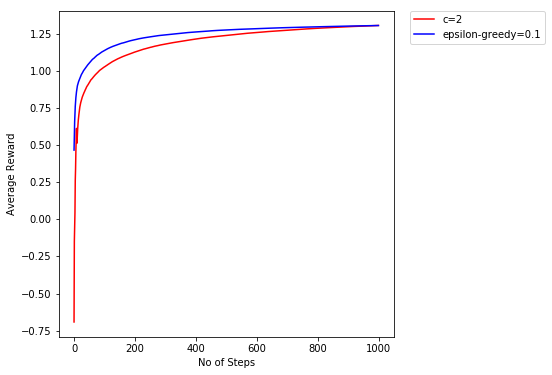

In [10]:
%%time
#UCB
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axes.plot(run_exps_ucb(c=2),color='r', label="c=2")
axes.plot(run_exps(epsilon=0.1),color='b',label="epsilon-greedy=0.1")
axes.set_xlabel("No of Steps")
axes.set_ylabel("Average Reward")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
def non_stationary(fixed_optimal_values, initial_expectation=0, k=10, epsilon=0, alpha=0.2, time_steps=1000):
    
    #tracking variables
    q_est = np.ones(k) * initial_expectation
    prev_trials = np.zeros(k)
    sum_prev_rewards = 0
    average_reward = list()
    
    #bandit environment returns reward
    def bandit(action_choosen):
        return np.random.normal(fixed_optimal_values[action_choosen], 1)
    
    #Simulation for time_steps
    for i in range(time_steps):
        
        if i%200==0:
            #Set seed so that for every condition and experiment the changes are same
            #Helps in comparison
            np.random.seed(i)
            changes = np.random.normal(0,1,k)
            fixed_optimal_values = np.add(fixed_optimal_values,changes)
        
        prob = np.random.random_sample()
        
        if prob <= epsilon:
            action_choosen = np.random.randint(0, 10)
        else:
            action_choosen = np.argmax(q_est)
        
        reward_t = bandit(action_choosen)
        prev_trials[action_choosen] += 1
        q_est[action_choosen] += (reward_t-q_est[action_choosen]) * alpha
        
        sum_prev_rewards += reward_t
        average_reward.append(sum_prev_rewards/(i+1))
        
    return average_reward

In [12]:
def run_exps_non(fixed_optimal_values=fixed_optimal_values, initial_expectation=0, k=10, epsilon=0, alpha=0.2, time_steps=1000, n=2000):
    average_return = list()
    for i in range(n):
        average_return.append(non_stationary(fixed_optimal_values, initial_expectation, k, epsilon, alpha, time_steps))
    
    return(np.mean(average_return, axis=0))

CPU times: user 29 s, sys: 104 ms, total: 29.1 s
Wall time: 29.1 s


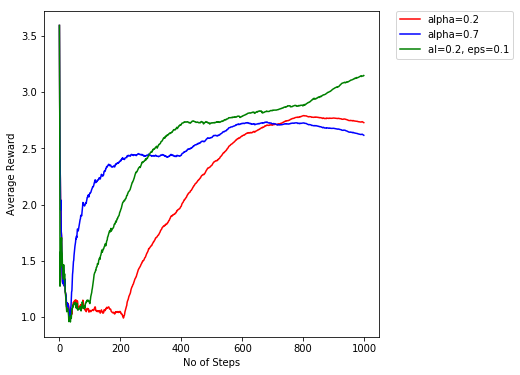

In [13]:
%%time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axes.plot(run_exps_non(alpha=0.2),color='r', label="alpha=0.2")
axes.plot(run_exps_non(alpha=0.7),color='b',label="alpha=0.7")
axes.plot(run_exps_non(alpha=0.2, epsilon=0.1), color='g', label="al=0.2, eps=0.1")
axes.set_xlabel("No of Steps")
axes.set_ylabel("Average Reward")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
def grad_bandit(fixed_optimal_values, k=10, alpha=0.2, time_steps=1000):
    
    #returns soft-max distribution
    def softmax(prefs):
        return np.exp(prefs)/np.sum(np.exp(prefs))
    
    #tracking variables
    prefs = np.zeros(k)
    prev_trials = np.zeros(k)
    sum_prev_rewards = 0
    avg_reward = 0
    average_reward_list = list()
    
    
    #bandit environment returns reward
    def bandit(action_choosen):
        return np.random.normal(fixed_optimal_values[action_choosen], 1)
    
    #Simulation for time_steps
    for i in range(time_steps):
        
        prob_action = softmax(prefs)
        action_choosen = np.random.choice(10, 1, p=prob_action)
        reward_t = bandit(action_choosen)
        sum_prev_rewards += reward_t
        
        avg_reward = sum_prev_rewards/(i+1)
        prefs = prefs - alpha*(reward_t-avg_reward)*prob_action
        prefs[action_choosen] = prefs[action_choosen] + alpha*(reward_t-avg_reward)*(1-prob_action[action_choosen]) 
        average_reward_list.append(avg_reward)
        
    return average_reward_list

In [15]:
def run_exps_grad(fixed_optimal_values=fixed_optimal_values, k=10, alpha=0.2, time_steps=1000, n=2000):
    average_return = list()
    for i in range(n):
        average_return.append(grad_bandit(fixed_optimal_values, k, alpha, time_steps))
    
    return(np.mean(average_return, axis=0))

CPU times: user 4min 12s, sys: 320 ms, total: 4min 12s
Wall time: 4min 12s


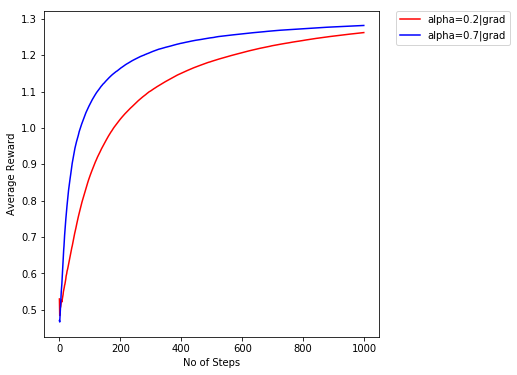

In [16]:
%%time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axes.plot(run_exps_grad(alpha=0.2),color='r', label="alpha=0.2|grad")
axes.plot(run_exps_grad(alpha=0.7),color='b',label="alpha=0.7|grad")
axes.set_xlabel("No of Steps")
axes.set_ylabel("Average Reward")
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)